# Proyecto Seminario ciencias de la computacion 
Horacio Araiza Gonzalez

Manuel Ignacio Gómez García

 **Se le proporcionan datos históricos de ventas diarias. La tarea consiste en prever la cantidad total de productos vendidos en cada tienda para el conjunto de pruebas. Tenga en cuenta que la lista de tiendas y productos cambia ligeramente cada mes. Crear un modelo robusto que pueda manejar estas situaciones es parte del reto.**

Importamos las librerias y iniciamos el entorno

In [1]:
!python -m pip install --user "findspark"

import os

# Import Spark libraries
import findspark
findspark.init()

import pyspark

In [2]:
from pyspark.sql import functions as f
from pyspark.sql import SparkSession, Window
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.functions import vector_to_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark = (SparkSession
        .builder
        .appName('parkML: Regression')
        .config("spark.debug.maxToStringFields", "100")
        .getOrCreate()
)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/23 23:32:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# **Cargar los conjuntos de datos de entrenamiento y prueba en Pyspark**

In [4]:
data = spark.read.csv("./sales_train.csv", header = True, inferSchema = True).limit(1000000)
test = spark.read.csv("./test.csv", header=True, inferSchema=True)

In [5]:
# Imprime el esquema de la trama de datos
data.printSchema()
print("Test data schema")
test.printSchema()

root
 |-- date: string (nullable = true)
 |-- date_block_num: integer (nullable = true)
 |-- shop_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- item_price: double (nullable = true)
 |-- item_cnt_day: double (nullable = true)

Test data schema
root
 |-- ID: integer (nullable = true)
 |-- shop_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)



In [6]:
data.show(10)

+----------+--------------+-------+-------+----------+------------+
|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|
+----------+--------------+-------+-------+----------+------------+
|02.01.2013|             0|     59|  22154|     999.0|         1.0|
|03.01.2013|             0|     25|   2552|     899.0|         1.0|
|05.01.2013|             0|     25|   2552|     899.0|        -1.0|
|06.01.2013|             0|     25|   2554|   1709.05|         1.0|
|15.01.2013|             0|     25|   2555|    1099.0|         1.0|
|10.01.2013|             0|     25|   2564|     349.0|         1.0|
|02.01.2013|             0|     25|   2565|     549.0|         1.0|
|04.01.2013|             0|     25|   2572|     239.0|         1.0|
|11.01.2013|             0|     25|   2572|     299.0|         1.0|
|03.01.2013|             0|     25|   2573|     299.0|         3.0|
+----------+--------------+-------+-------+----------+------------+
only showing top 10 rows



In [7]:
print("Column number:", len(data.columns))
print("Raw data summary:")
data.summary().show()

Column number: 6
Raw data summary:


+-------+----------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|      date|   date_block_num|           shop_id|          item_id|       item_price|      item_cnt_day|
+-------+----------+-----------------+------------------+-----------------+-----------------+------------------+
|  count|   1000000|          1000000|           1000000|          1000000|          1000000|           1000000|
|   mean|      null|         4.208071|          32.73796|     10225.080515|675.9365139514163|          1.208791|
| stddev|      null|2.830910361175782|16.327174514134846|6285.262987518039|1117.935671758554|1.5283355829557383|
|    min|01.01.2013|                0|                 0|               12|             -1.0|              -6.0|
|    25%|      null|                2|                22|             4565|            199.0|               1.0|
|    50%|      null|                4|                31|             9661|            399.0|   

# Preprocesamiento de datos

In [8]:
# Realizar semi-join
train = (data.join(test, ["shop_id", "item_id"], "semi")
              .select(data.columns))
# Ver si el número de filas disminuye
print("Rows after joining:", train.count())
print("Summary:")
train.summary().show()

Rows after joining: 203689
Summary:


+-------+----------+------------------+-----------------+-----------------+-----------------+------------------+
|summary|      date|    date_block_num|          shop_id|          item_id|       item_price|      item_cnt_day|
+-------+----------+------------------+-----------------+-----------------+-----------------+------------------+
|  count|    203689|            203689|           203689|           203689|           203689|            203689|
|   mean|      null| 4.682020138544546| 31.8259552553157|9395.259567281493| 723.939446945255|1.4023388597322388|
| stddev|      null|2.8329934872957665|16.27862922937888|6337.094718423836|771.6447985623448|2.6330950633016816|
|    min|01.01.2013|                 0|                2|               30|              3.0|              -6.0|
|    25%|      null|                 2|               19|             3719|            249.0|               1.0|
|    50%|      null|                 5|               31|             7734|            449.0|   

In [9]:
train = train.where((train.item_price >= 0) & (train.item_cnt_day >= 0))
train.count()

203252

In [10]:
train = (
    train.groupBy(["date_block_num", "shop_id", "item_id"]).agg(
        f.sum("item_price").alias("all_itemPrice_month"), # Sum of item prices by each item per month
        f.mean("item_price").alias("mean_itemPrice_month"), # Mean of item prices by each item per month
        f.sum("item_cnt_day").alias("item_cnt_month"), # Total item sold per month
        f.mean("item_cnt_day").alias("mean_itemCnt_month"), # Mean of item sold per month
        f.count("item_cnt_day").alias("days_sold_month") # Number of days the item is sold each month
    ).withColumnRenamed("date_block_num", "month_index")
)

train.summary().show()

+-------+-----------------+------------------+-----------------+-------------------+--------------------+------------------+------------------+------------------+
|summary|      month_index|           shop_id|          item_id|all_itemPrice_month|mean_itemPrice_month|    item_cnt_month|mean_itemCnt_month|   days_sold_month|
+-------+-----------------+------------------+-----------------+-------------------+--------------------+------------------+------------------+------------------+
|  count|            92419|             92419|            92419|              92419|               92419|             92419|             92419|             92419|
|   mean|4.654984364686915|31.719527369913113|9860.909488308682| 1590.3340518597859|   660.2045339573962|3.0955755851069586| 1.103838422628086| 2.199244744046138|
| stddev|2.799396526410254| 16.73984827197512|6127.187557430541|  3365.292954159378|   753.9643129643918|13.283945507971122|0.8943617708534444|2.5989415226728676|
|    min|             

In [11]:
sampling_ratio = 1 # Cambia esto si el tamaño de los datos es demasiado grande
itemPrices = train.select("all_itemPrice_month").rdd.map(lambda row: row.all_itemPrice_month).sample(False, sampling_ratio, 19127191).collect()
itemCounts = train.select("item_cnt_month").rdd.map(lambda row: row.item_cnt_month).sample(False, sampling_ratio, 19127191).collect()

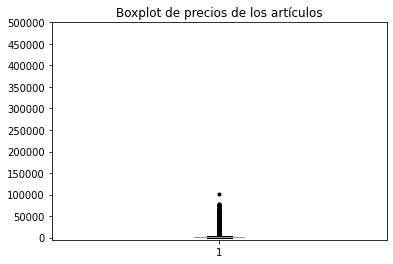

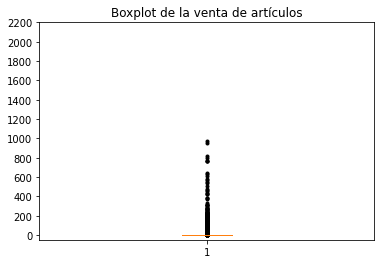

In [12]:
# Dibuja boxplots de las 2 características para comprobar si hay valores atípicos

# Precios de los artículos
plt.boxplot(itemPrices, sym='k.')
plt.yticks(np.arange(0, 550000, 50000))
plt.title("Boxplot de precios de los artículos")
plt.show()

print()
# Venta de artículos
plt.boxplot(itemCounts, sym='k.')
plt.yticks(np.arange(0, 2400, 200))
plt.title("Boxplot de la venta de artículos")
plt.show()

In [13]:
train = train.where((train.all_itemPrice_month <= 400000) & (train.item_cnt_month <= 800))
train.count()

92416

In [14]:
combinations = (
    (train.select("month_index").distinct()).crossJoin(
        train.select("shop_id").distinct())
    ).crossJoin(
        train.select("item_id").distinct()
    )

In [15]:
train_monthly = train.join(combinations, ["month_index", "shop_id", "item_id"], "rightouter")
train_monthly = train_monthly.fillna(0) # rellenar los valores que faltan

# Realiza una operación de ordenación para mantener el orden de las series temporales
train_monthly = train_monthly.orderBy(["month_index", "shop_id", "item_id"], ascending=[1,1,1])

In [16]:
print("10 first samples:")
train_monthly.show(10)

10 first samples:


+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+
|month_index|shop_id|item_id|all_itemPrice_month|mean_itemPrice_month|item_cnt_month|mean_itemCnt_month|days_sold_month|
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+
|          0|      2|     30|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     31|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     32|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     33|              499.0|               499.0|           1.0|               1.0|              1|
|          0|      2|     42|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     45|   

# Exploratory Data Analysis (EDA)

In [17]:
train_monthly = (
    train_monthly.withColumn("month", train_monthly.month_index % 12)
                 .withColumn("year", (train_monthly.month_index / 12).cast("int") + 2013)
)

train_monthly.columns

['month_index',
 'shop_id',
 'item_id',
 'all_itemPrice_month',
 'mean_itemPrice_month',
 'item_cnt_month',
 'mean_itemCnt_month',
 'days_sold_month',
 'month',
 'year']

In [18]:
month_index_means = train_monthly.groupBy("month_index").agg(f.mean("item_cnt_month").alias("month_index_mean")).orderBy("month_index")
month_means = train_monthly.groupBy("month").agg(f.mean("item_cnt_month").alias("month_mean")).orderBy("month")

In [19]:
# Convertir los datos en una lista usando Spark RDD y luego graficarlos con mathplotlib
months = range(12)
month_indices = range(34)
lMonthMean = month_means.rdd.map(lambda row: row.month_mean).collect()
lMonthIdxMean = month_index_means.rdd.map(lambda row: row.month_index_mean).collect()

# Feature engineering

Después de realizar el preprocesamiento y el análisis, empezaremos a convertir los datos de las series temporales en datos de regresión. En primer lugar, vamos a crear la columna de predicción para nuestros datos.
Originalmente, este conjunto de datos utiliza item_cnt_month para la columna objetivo. Sin embargo, como serie temporal, lo que pretendemos predecir es el valor de las ventas del mes siguiente. Para convertir este problema en un problema de regresión, añadimos una columna que diga "predicción de ventas para el próximo mes" utilizando las ventas de la fila siguiente a la actual. Esta será nuestra columna objetivo.



In [20]:
window = Window.orderBy("month_index").partitionBy(["shop_id", "item_id"])
rolling_window = Window.orderBy("month_index").partitionBy(["shop_id", "item_id"]).rangeBetween(-2, 0)

In [21]:
train_monthly = train_monthly.select(
    "*",
    f.lag("item_cnt_month", offset=-1, default=0).over(window).alias("itemCnt_nextMonth")
)

In [22]:
train_monthly = train_monthly.select(
    "*",
    f.lag("item_cnt_month", offset=1, default=0).over(window).alias("itemCnt_lag_1"),
    f.lag("item_cnt_month", offset=2, default=0).over(window).alias("itemCnt_lag_2")
)

In [23]:
# Crear la función itemCnt_trendCycle
train_monthly = train_monthly.withColumn(
    "itemCnt_trendCycle",
    (train_monthly.item_cnt_month - train_monthly.itemCnt_lag_1 - train_monthly.itemCnt_lag_2) / 3
)

In [24]:
train_monthly = (train_monthly.withColumn("item_cnt_min", f.min("item_cnt_month").over(rolling_window))
                              .withColumn("item_cnt_max", f.max("item_cnt_month").over(rolling_window))
                              .withColumn("item_cnt_mean", f.mean("item_cnt_month").over(rolling_window))
                              .withColumn("item_cnt_std", f.stddev("item_cnt_month").over(rolling_window))
)

In [25]:
train_monthly = train_monthly.fillna(0)

In [26]:
print("First 10 samples:")
train_monthly.show(10)
print("Summary:")
train_monthly.summary().show()

First 10 samples:


+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+-----+----+-----------------+-------------+-------------+-------------------+------------+------------+------------------+------------------+
|month_index|shop_id|item_id|all_itemPrice_month|mean_itemPrice_month|item_cnt_month|mean_itemCnt_month|days_sold_month|month|year|itemCnt_nextMonth|itemCnt_lag_1|itemCnt_lag_2| itemCnt_trendCycle|item_cnt_min|item_cnt_max|     item_cnt_mean|      item_cnt_std|
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+-----+----+-----------------+-------------+-------------+-------------------+------------+------------+------------------+------------------+
|          0|      2|     31|                0.0|                 0.0|           0.0|               0.0|              0|    0|2013|              4.0|          0.0|          0.0|                0.0|         0.0|    

+-------+-----------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-----------------+------+-------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+-------------------+
|summary|      month_index|           shop_id|           item_id|all_itemPrice_month|mean_itemPrice_month|    item_cnt_month| mean_itemCnt_month|   days_sold_month|            month|  year|  itemCnt_nextMonth|     itemCnt_lag_1|     itemCnt_lag_2|  itemCnt_trendCycle|       item_cnt_min|      item_cnt_max|     item_cnt_mean|       item_cnt_std|
+-------+-----------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-----------------+------+-------------------+------------------+------------------+--------------------+-------------------+------------------

# Train-Validation Split

In [27]:
# Dividimos nuestros datos en 3 conjuntos
train_set = train_monthly.where("month_index > 1 and month_index < 7")#7
validation_set = train_monthly.where("month_index >= 7 and month_index < 9")#9
test_set = train_monthly.where("month_index >= 9")

# Eliminar las filas con valores nulos
train_set = train_set.dropna()
validation_set = validation_set.dropna()

In [28]:
# Agrega la codificación media de las características categóricas
shop_mean = train_set.groupBy("shop_id").agg(f.mean("itemCnt_nextMonth").alias("shop_mean"))
item_mean = train_set.groupBy("item_id").agg(f.mean("itemCnt_nextMonth").alias("item_mean"))
year_mean = train_set.groupBy("year").agg(f.mean("itemCnt_nextMonth").alias("year_mean"))
month_mean = train_set.groupBy("month").agg(f.mean("itemCnt_nextMonth").alias("month_mean"))

In [29]:
# Añadir la característica de codificación media derivada del conjunto de entrenamiento a todos los conjuntos
# Conjunto de entrenamiento
train_set = train_set.join(shop_mean, ["shop_id"], "left")
train_set = train_set.join(item_mean, ["item_id"], "left")
train_set = train_set.join(year_mean, ["year"], "left")
train_set = train_set.join(month_mean, ["month"], "left")
train_set = train_set.withColumn("itemCnt_nextMonth", f.col("itemCnt_nextMonth").cast("int"))
train_set = train_set.drop("month_index") # Suprima esta columna porque ya tenemos la codificación media de los meses y los años

# Conjunto de validación
validation_set = validation_set.join(shop_mean, ["shop_id"], "left")
validation_set = validation_set.join(item_mean, ["item_id"], "left")
validation_set = validation_set.join(year_mean, ["year"], "left")
validation_set = validation_set.join(month_mean, ["month"], "left")
validation_set = validation_set.withColumn("itemCnt_nextMonth", f.col("itemCnt_nextMonth").cast("int"))
validation_set = validation_set.drop("month_index")

# Conjunto de pruebas
test_set = test_set.join(shop_mean, ["shop_id"], "left")
test_set = test_set.join(item_mean, ["item_id"], "left")
test_set = test_set.join(year_mean, ["year"], "left")
test_set = test_set.join(month_mean, ["month"], "left")
test_set = test_set.withColumn("itemCnt_nextMonth", f.col("itemCnt_nextMonth").cast("int"))
test_set = test_set.drop("itemCnt_nextMonth")
test_set = test_set.drop("month_index")

# Añadir productos que nunca existen en los datos de formación durante la fase de generación de la combinación de registros, pero sí en los datos de prueba
test_columns = test_set.columns
test_set = test.join(test_set, on=["shop_id", "item_id"], how="left")

# Reordenar las columnas de los 3 conjuntos para que coincidan entre sí
train_set = train_set.select(sorted(train_set.columns))
validation_set = validation_set.select(sorted(train_set.columns))
test_set = test_set.select(sorted(test_columns))

# Rellenar todos los valores nulos con 0
train_set = train_set.fillna(0)
validation_set = validation_set.fillna(0)
test_set = test_set.fillna(0)

In [30]:
train_set.printSchema()
validation_set.printSchema()
test_set.printSchema()

root
 |-- all_itemPrice_month: double (nullable = false)
 |-- days_sold_month: long (nullable = true)
 |-- itemCnt_lag_1: double (nullable = false)
 |-- itemCnt_lag_2: double (nullable = false)
 |-- itemCnt_nextMonth: integer (nullable = true)
 |-- itemCnt_trendCycle: double (nullable = false)
 |-- item_cnt_max: double (nullable = false)
 |-- item_cnt_mean: double (nullable = false)
 |-- item_cnt_min: double (nullable = false)
 |-- item_cnt_month: double (nullable = false)
 |-- item_cnt_std: double (nullable = false)
 |-- item_id: integer (nullable = true)
 |-- item_mean: double (nullable = false)
 |-- mean_itemCnt_month: double (nullable = false)
 |-- mean_itemPrice_month: double (nullable = false)
 |-- month: integer (nullable = true)
 |-- month_mean: double (nullable = false)
 |-- shop_id: integer (nullable = true)
 |-- shop_mean: double (nullable = false)
 |-- year: integer (nullable = true)
 |-- year_mean: double (nullable = false)

root
 |-- all_itemPrice_month: double (nullable 

In [31]:
# Reestructurar el conjunto de entrenamiento
inputColumns = train_set.drop("itemCnt_nextMonth").columns
assembler1 = VectorAssembler(inputCols=inputColumns, outputCol="features")
train_assembled = assembler1.transform(train_set).select(["features", "itemCnt_nextMonth"])

# Reestructurar el conjunto de validación
inputColumns = validation_set.drop("itemCnt_nextMonth").columns
assembler2 = VectorAssembler(inputCols=inputColumns, outputCol="features")
validation_assembled = assembler2.transform(validation_set).select(["features", "itemCnt_nextMonth"])

# Reestructurar el conjunto de pruebas
inputColumns = test_set.columns
assembler3 = VectorAssembler(inputCols=inputColumns, outputCol="features")
test_assembled = assembler3.transform(test_set).select(["features"])

In [32]:
# Comprueba de nuevo el esquema
train_assembled.printSchema()
validation_assembled.printSchema()
test_assembled.printSchema()

root
 |-- features: vector (nullable = true)
 |-- itemCnt_nextMonth: integer (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- itemCnt_nextMonth: integer (nullable = true)

root
 |-- features: vector (nullable = true)



In [33]:
train_maxVal = train_set.groupby().max('itemCnt_nextMonth').collect()[0].asDict()['max(itemCnt_nextMonth)']
train_minVal = train_set.groupby().min('itemCnt_nextMonth').collect()[0].asDict()['min(itemCnt_nextMonth)']
validation_maxVal = validation_set.groupby().max('itemCnt_nextMonth').collect()[0].asDict()['max(itemCnt_nextMonth)']
validation_minVal = validation_set.groupby().min('itemCnt_nextMonth').collect()[0].asDict()['min(itemCnt_nextMonth)']

# Modelando los datos
Ahora podemos utilizar modelos de aprendizaje automático para realizar una regresión sobre los datos procesados.

### Regresión lineal
En primer lugar, debemos reescalar/normalizar las características. Este es un paso necesario para la regresión lineal.

In [34]:
# Reescalar el conjunto de entrenamiento
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_assembled)
train_scaled = scaler_model.transform(train_assembled).select(["scaledFeatures", "itemCnt_nextMonth"])

# Reescalar el conjunto de validación
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(validation_assembled)
validation_scaled = scaler_model.transform(validation_assembled).select(["scaledFeatures", "itemCnt_nextMonth"])



22/05/23 23:35:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/05/23 23:36:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


 Antes de utilizar la regresión lineal, deberíamos utilizar un selector de características para reducir la dimensionalidad de los datos, lo que reducirá el tiempo de entrenamiento y el exceso de ajuste. Aquí utilizaremos el selector de características univariante para seleccionar el 30% de las mejores características del conjunto de entrenamiento. El selector se ajustará al conjunto de entrenamiento, y luego lo utilizaremos para transformar tanto el conjunto de entrenamiento como el de validación.



In [35]:
selector = UnivariateFeatureSelector(featuresCol="scaledFeatures", outputCol="selectedFeatures", labelCol="itemCnt_nextMonth", selectionMode="percentile")
selector.setFeatureType("continuous").setLabelType("continuous").setSelectionThreshold(0.3)
selector_model = selector.fit(train_scaled)
train_selected = selector_model.transform(train_scaled).select(["selectedFeatures", "itemCnt_nextMonth"])
validation_selected = selector_model.transform(validation_scaled).select(["selectedFeatures", "itemCnt_nextMonth"])

In [36]:
train_selected.head().selectedFeatures

DenseVector([7.417, 18.9685, 25.64, 0.0, -9.4305, 18.2747])




Así que se han seleccionado 6 características de entre las 20 del conjunto de entrenamiento. Utilizaremos la característica seleccionada para entrenar el modelo de regresión lineal.





In [37]:
lr = LinearRegression(featuresCol="selectedFeatures", labelCol="itemCnt_nextMonth", regParam=0.3, elasticNetParam=0.3, maxIter=10)
lr_model = lr.fit(train_selected)

22/05/23 23:39:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/23 23:39:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/23 23:39:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [38]:
trainingSummary = lr_model.summary
print("Train RMSE:", trainingSummary.rootMeanSquaredError)
print("Train Adjusted R2:", trainingSummary.r2adj)

Train RMSE: 3.821472856889721
Train Adjusted R2: 0.4995803404890903


El valor R2 ajustado indica que aproximadamente el 54,9% ~ 55% de los registros de nuestro conjunto de entrenamiento pueden utilizarse para explicar los registros objetivo. Esto se debe a que originalmente llenamos nuestro conjunto de entrenamiento con muchos registros vacíos utilizando las combinaciones de (month_index, shop_id, item_id). Mientras el valor R2 ajustado sea superior al 50%, podemos considerar que nuestro modelo es lo suficientemente bueno para la evaluación.
Para entender mejor el valor de RMSE, lo normalizamos con respecto al rango de resultados del conjunto de entrenamiento (máximo y mínimo de itemCnt_nextMonth). Esto escalará el RMSE entre 0 y 1. Cuanto más cerca esté de 0, más se ajusta nuestro modelo, pero si es completamente 0, significa que el modelo está sobreajustado por lo que debemos tener cuidado.

In [39]:
print("Normalized RMSE:", trainingSummary.rootMeanSquaredError / (train_maxVal - train_minVal))

Normalized RMSE: 0.004782819595606659


Parece que el error normalizado en el conjunto de entrenamiento es bastante pequeño. Eso significa que nuestro modelo es lo suficientemente bueno. Ahora vamos a probarlo en el conjunto de validación.

In [40]:
# Dejamos que el modelo prediga el conjunto de validación
lr_predictions = lr_model.transform(validation_selected)

# Utilizamos un evaluador de regresión para evaluar los resultados de la predicción
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="itemCnt_nextMonth",metricName="rmse")
validation_rmse = lr_evaluator.evaluate(lr_predictions)
print("Validation RMSE:", validation_rmse)


Validation RMSE: 5.564923944753682


De nuevo, normalicemos este error para tener una mejor comprensión de la evaluación.

In [41]:
print("Normalized validation RMSE:", validation_rmse / (validation_maxVal - validation_minVal))

Normalized validation RMSE: 0.00728393186486084


Por lo tanto, podemos ver que con el RMSE normalizado muy cercano a 0, el modelo de regresión lineal está suficientemente bien ajustado. Dado que el RMSE del conjunto de validación es ligeramente superior al del conjunto de entrenamiento, es posible que haya un exceso de ajuste, pero la diferencia es lo suficientemente pequeña.

### Random Forest Regression  
A diferencia de la regresión lineal, el bosque aleatorio puede hacer una selección de características de forma inherente, por lo que sólo tenemos que entrenarlo con todas las características reunidas.

In [42]:
rf = RandomForestRegressor(featuresCol="features", labelCol="itemCnt_nextMonth", numTrees=50, maxDepth=7)
rf_model = rf.fit(train_assembled)

Como el regresor de bosque aleatorio de PySpark no puede dar el resumen de entrenamiento, pasaremos a la fase de evaluación.

In [43]:
# Utilizar el modelo para predecir en el conjunto de validación
rf_predictions = rf_model.transform(validation_assembled)

# Utilice un evaluador de regresión para evaluar los resultados de la predicción
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="itemCnt_nextMonth",metricName="rmse")
rf_validation_rmse = rf_evaluator.evaluate(rf_predictions)
print("Validation RMSE:", rf_validation_rmse)
print("Normalized validation RMSE:", rf_validation_rmse / (validation_maxVal - validation_minVal))

Validation RMSE: 5.175559578176212
Normalized validation RMSE: 0.0067742926415919


Podemos ver que el RMSE de validación y el RMSE normalizado de este modelo es menor que el RMSE de validación anterior. Parece que el modelo de regresión de Random Forest es mejor que el modelo de regresión lineal. Veamos qué importancia da el modelo de bosque aleatorio a cada característica.

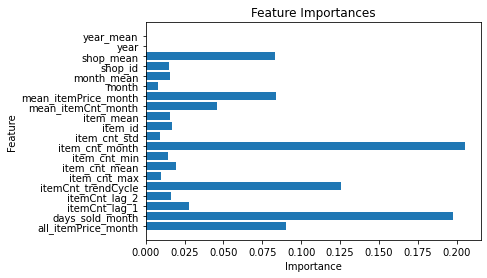

In [44]:
# Obtener la lista de importancia de las características del bosque aleatorio
importance = rf_model.featureImportances

# Dibuja un gráfico de barras para ver las características
inputColumns = train_set.columns.copy()
inputColumns.remove("itemCnt_nextMonth")
plt.barh(inputColumns, importance)
plt.title("Feature Importances")
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

El modelo Random Forest determina que el número de ventas del mes actual (days_sold_month) es la característica más importante, lo que es correcto con el funcionamiento de la serie temporal. Las siguientes 4 características más importantes son:  
- Codificación media del identificador de la tienda (shop_mean),  
- Las características basadas en la ventana móvil para la moda en cuestión y su precio a lo largo del mes (itemCnt_trendCycle, all_itemPrice_month),  
- El número de días del mes en que se vende un producto (item_cnt_month).

In [45]:
# Hacer una predicción
november_predictions = rf_model.transform(test_assembled)

In [46]:
# Obtener las columnas shop_id, item_id y resultado de la predicción del conjunto de pruebas ensamblado
results = (november_predictions
    .withColumn("feature", vector_to_array("features"))
    .select([f.col("feature")[i] for i in [16, 10]] + ["prediction"])
    .withColumnRenamed("feature[16]", "shop_id")
    .withColumnRenamed("feature[10]", "item_id")
    .withColumnRenamed("prediction", "days_sold_month")
    .withColumn("shop_id", f.col("shop_id").cast("int"))
    .withColumn("item_id", f.col("item_id").cast("int"))
)

results.show()

+-------+-------+-------------------+
|shop_id|item_id|    days_sold_month|
+-------+-------+-------------------+
|      5|   4055|0.06652470351035548|
|      5|  10449|0.06652470351035548|
|      5|   7931|0.06652470351035548|
|      5|  15285|0.06932351070006301|
|      5|   1246|0.06652470351035548|
|      5|  15553|0.06932351070006301|
|      5|  21881|0.06932351070006301|
|      5|   4895|0.06652470351035548|
|      5|   6674|0.06652470351035548|
|      5|  10448|0.06652470351035548|
|      5|   5896| 1.3921043330985545|
|      5|  10324|0.07050270294107858|
|      5|   7655|0.06652470351035548|
|      5|  10653|0.07050270294107858|
|      5|  11323|0.07967641990312506|
|      5|  20377| 0.0824752270928326|
|      5|   6630|0.06652470351035548|
|      5|   6523|0.06652470351035548|
|      5|  10750|0.06652470351035548|
|      5|  11574|0.07050270294107858|
+-------+-------+-------------------+
only showing top 20 rows



In [47]:
# Unir el conjunto de datos de prueba original con el conjunto de resultados para obtener la columna ID de la tupla
submission = test.join(results, on=["shop_id", "item_id"], how="left").select(["ID", "days_sold_month"]).orderBy("ID")

# Redondea la predicción a 2 decimales
submission = submission.withColumn("days_sold_month", f.round("days_sold_month", 2))

submission.show()

22/05/23 23:42:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+---+---------------+
| ID|days_sold_month|
+---+---------------+
|  0|           0.07|
|  1|           0.07|
|  2|           0.07|
|  3|           0.07|
|  4|           0.07|
|  5|           0.07|
|  6|           0.07|
|  7|           0.07|
|  8|           0.07|
|  9|           0.07|
| 10|           0.07|
| 11|           0.07|
| 12|           0.12|
| 13|           0.07|
| 14|           3.73|
| 15|           0.07|
| 16|           0.07|
| 17|           0.07|
| 18|           0.07|
| 19|           0.07|
+---+---------------+
only showing top 20 rows

